In [48]:
#plotting the Power Law fit with PLFit function, modified
import numpy as np
import yt
import time
from yt.funcs import mylog
import matplotlib.pyplot as plt
mylog.setLevel(40) #prevents warning
plt.style.use('default')
import scipy
from scipy import optimize
from pdf_fitter import *
import pandas as pd
plt.rcParams["font.family"] = "serif"

In [49]:
###all setup condensed to one block. no need to rerun between trials
#only cell in need of changing between runs
inputfile = ('/scratch/jak491/npz_storage/vol_covering_grid_den0.npz','/scratch/jak491/npz_storage/vol_covering_grid_den1.npz','/scratch/jak491/npz_storage/vol_covering_grid_den2.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den3.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den4.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den5.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den_high.npz')
percent = 5
perc = '5'
titles = ('gravity ','turbulence', 'magnetic fields', 'all+ outflows')
slopes =[]
slopes_error = []
sigmas = []
sigmas_error = []
#titles = ('10% SFE\nG','10% SFE\nG+T','10% SFE\nG+T+M','6% SFE\nG+T+M+P' )
sigma_limit = 2
slope_limit = 2

#define Linear function 
def linear(x, m, b): 
    return m*x + b    
#define Log Normal function
def lognorm(x,mu,sigma):
    return np.log((1/(np.sqrt(2*np.pi*sigma**2)))*(np.exp(-((x-mu)**2)/(2*sigma**2))))
 
#plot setup
d = {}
variable_name =('density_g','density_gt','density_gtm', 'density_gtmp')
input_file = inputfile[percent]
plot_data = np.load(input_file, allow_pickle=True)

#editting the package to allow small sigma
class Params():
    def __init__(self, root_finding_lower_lim= -15, root_finding_upper_lim=1, root_finding_step_size=0.2, \
                root_finding_max_tries=40, s_cut_off = 10, y_min_cut_off=0, bounds = [(0,1.01,0.3,3),(5,5,5,10)],\
                shrink_data = 4, debug=False, single_bounds=[(.1,.1),(5,5)]):
        
        ''' Parameters: 
        root_finding_lower_lim - This is the lower limit for the root finding range.
        root_finding_upper_lim - This is the upper limit for the root finding range.
        root_finding_step_size - This is the step_size for root finding. Range shrinks by this value after each iteration.
        root_finding_max_tries - This is the maximum number of attempts to make at root_finding.
        s_cut_off - The maximum cut-off for the x values.
        y_min_cut_off - The minimum cut-off for the y-values.
        bounds - The bounds of the parameters (double PL case).
        shrink_data - The number of data points to remove from the edges.
        debug - Flag for printing the parameter values while fitting is ongoing.
        single_bounds - The bounds of the fitted parameters (single PL case).
        '''
        self.root_finding_lower_lim=root_finding_lower_lim
        self.root_finding_upper_lim=root_finding_upper_lim
        self.root_finding_step_size=root_finding_step_size   #This means the range shrinks by 0.2 (default) everytime.
        self.root_finding_max_tries=root_finding_max_tries
        self.s_cut_off=s_cut_off
        self.y_min_cut_off=y_min_cut_off
        self.bounds = bounds
        self.shrink_data = shrink_data                       #Removing some data points from the edges helps to fit better.
        self.debug=debug
        self.single_bounds=single_bounds
        


starting
0


TypeError: '>' not supported between instances of 'list' and 'int'

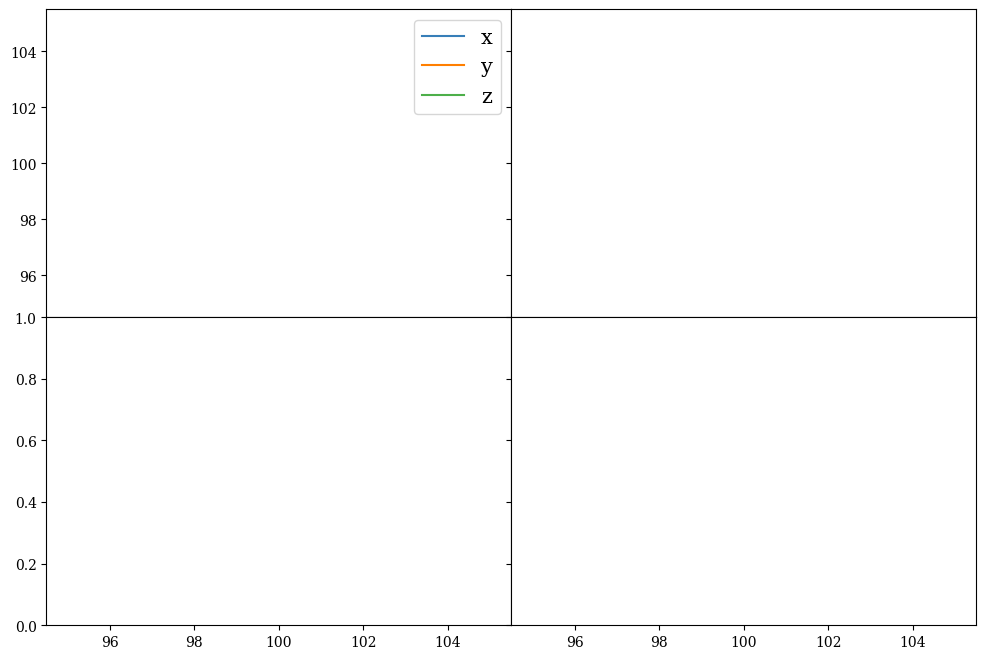

In [51]:
#power law fitting. 
start = time.time()
print('starting')
slopes = []
transit =[]
transit_error = []
error = []
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,8), sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})

ax =ax.ravel()
#plt.suptitle('Column Densities with ' + perc + '% SFE', size =26)
#ax[0].annotate(' log upper limit = .75\n linear lower limit = 1',[-2,1e-5], size =15)

ax[0].plot(100,100, color = '#377eb8', alpha =1)
ax[0].plot(100,100, color = '#ff7f00', alpha =1)
ax[0].plot(100,100, color = '#4daf4a', alpha =1)
ax[0].legend([ 'x', 'y', 'z'],fontsize =15)
b = 0

for n in range(4):
    den = plot_data[plot_data.files[n]]
    color_list = ('#377eb8', '#ff7f00', '#4daf4a')
    print(n)     #for time keeping
    
    for a in (range(1)):
        log_den_d = plot_data[plot_data.files[b]]
        counts_d, binS_d = np.histogram(log_den_d,bins=50, density= True)
        b = b+1
        #trying to cut off all points below -3
        bins = []
        counts = []
        for L in range(len(binS_d)):
            if binS_d[L] > -3:
                bins.append(binS_d[L])
                if L < 50:
                    counts.append(counts_d[L])

        bin_list = []
        for i in range(len(bins)-1):
            bin_i=(bins[i]+bins[i+1])/2
            bin_list.append(bin_i)

#######################################################################################
        #power fit specifics
        xdata = bin_list
        ydata = counts
        #p0= (sigma, alpha)
        p0=[.66, 3]
        params = Params(s_cut_off = 6) #cut off for x, the maximum value of x
        results = PLFit(xdata, ydata, p0, params)#, use_K21=True)
        y_int = .6
        sigma_limit = results.sg
        slope_limit = results.sg
        trans = results.sg
        trans_error = results.sg_err
        transit.append(trans)
        transit_error.append(trans_error)
        slope = results.alpha_g
        slopes.append(slope)
        sigma = results.sigma
        sigmas.append(sigma)
        slope_error = results.alpha_g_err
        slopes_error.append(slope_error)
        sigma_error = results.sigma_err
        sigmas_error.append(sigma_error)
#######################################################################################
        #create subrange and plots linear fit
        x =[]
        y = []
        x_log =[]
        y_log = []
        for i in range(len(bin_list)):
            if bin_list[i] > slope_limit:
                if counts_d[i] > 0:
                        x.append(bin_list[i])
                        y.append(counts_d[i])
                else:
                    break

        #create subrange and plots linear fit
        x =[]
        y = []
        x_log =[]
        y_log = []
        for i in range(len(bin_list)):
            if bin_list[i] > slope_limit:
                if counts_d[i] > 0:
                        x.append(bin_list[i])
                        y.append(counts_d[i])
                else:
                    break
        for i in range(len(bin_list)):
            if bin_list[i] < sigma_limit:
                    x_log.append(bin_list[i])
                    y_log.append(counts_d[i])
            else:
                break
                
        
        log_param, log_con = scipy.optimize.curve_fit(lognorm, x_log, np.log(y_log))
        y_log = lognorm(np.array(x_log),results.s0,results.sigma)
        #find y intercept
        m = -1*results.alpha_g
        x_b = x_log[len(x_log)-1]
        y_b = y_log[len(y_log)-1]
        b_log =  y_b-(m*x_b)
        
        y = linear(np.array(x),m,b_log)

        
        ax[n].plot(x,np.exp(y), color = color_list[a])
        ax[n].plot(x_log,np.exp(y_log), color = color_list[a])

    
        ax[n].plot(bin_list, counts_d, color = color_list[a], alpha = .3)
        #ax[n].plot(x,np.exp(y), color = color_list[a])


        
    if n > 1:
        ax[n].set_xlabel(r'ln($N/N_0$)', size=25)
    if n == 0 or n == 2:
        ax[n].set_ylabel(r'p(ln($N/N_0$))', size=25)
    

    ax[n].annotate(titles[n], (4,.2), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))

    #ax[n].set_title(titles[n], size = 17)
    ax[n].tick_params(direction='in', length=6, size = 10, labelsize = 14)
    ax[n].set_yscale('log')
    ax[n].set_ylim(10**(-7.5),1.1)
    ax[n].set_xlim(-9,12)
    ax[n].tick_params(direction='in', length=10, labelsize = 15, which = 'major')

    ax[n].set_xticks((-8,-4,0,4,8))
    ax[n].set_yticks((1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6))

plt.tight_layout()
plt.subplots_adjust(top=.85)
plt.savefig('PLFit_vol_'+perc+'%.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

file = open("txt_file_storage/vol_power_fit_slope" +perc+"%.txt", "w")
str_dictionary = repr(slopes)
file.write(str_dictionary + "\n")
str_dictionary = repr(slopes_error)
file.write(str_dictionary + "\n")
file.close()

file = open("txt_file_storage/vol_power_fit_sigma" +perc+"%.txt", "w")
str_dictionary = repr(sigmas)
file.write(str_dictionary + "\n")
str_dictionary = repr(sigmas_error)
file.write(str_dictionary + "\n")
file.close()

file = open("txt_file_storage/vol_trans_density" +perc+"%.txt", "w")
str_dictionary = repr(transit)
file.write(str_dictionary + "\n")
str_dictionary = repr(transit_error)
file.write(str_dictionary + "\n")
file.close()

end = time.time()
print("time:",(end-start)/60)

In [6]:
len(log_den_d)

25063424

time: -14.854271054267883


In [13]:
len(log_den)

23285091

In [40]:
bins = []
counts = []
for L in range(len(binS_d)):
    if binS_d[L] > 3:
        bins.append(binS_d[L])
        if L < 50:
            counts.append(counts_d[L])


11.216630698153773

In [46]:
len(ydata)

31